<a href="https://colab.research.google.com/github/WNderitu/Malaria-Parasite-Detector-version-2/blob/main/4_hyperparametertune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Plasmodium Vivax (malaria) parasite detector and counter**

**Notebook 4: Hyperparameter tuning Notebook**

- YOLOv8n model variant/size

In [2]:
from google.colab import drive

# Mount Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully!")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")

Mounted at /content/drive
Google Drive mounted successfully!


## **4.0 Install required libraries**

In [3]:
!pip install matplotlib --quiet
!pip install Pillow --quiet #installing PILLOW LIBRARY
!pip install imagehash --quiet
!pip install pyyaml --quiet
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.6 MB/s eta 0:00:00


## **4.1 Model Hyperparameter tuning**

### *4.1.1 Optimal Hyperparameter Tuning Strategy*



1. Difficult class remapped to Trophozoite class in data preparation finetune notebook

2. Schizont - worst performing class,increase its class weight.

3. Gametocyte - increase class weight.

4. Reduce learning rate further, consider cosine learning rate scheduler.

5. Reduce number of epochs & patience

6. Consider adding extent of geometric augmentations - **scale=0.7 for More scale variation (from 0.5)**

7. Increase weights for Schizont, Ring & Gaemtocyte classes

8. Decrease weight of Trophozoite & RBC classes

9. Keep leukocyte class weight

- RBC:0.1735 <- 0.15
- Leukocyte: 107.7996 - Keep
- Schizont: 66.0961 -> x3
- Ring: 31.6614 -> slight increase
- Gametocyte:74.8361 -> x2
- Trophozoite:5.9928 <-

### *4.1.2 Preparation of best.pt from first model train*

In [ ]:
# import os
# from ultralytics import YOLO

# # --- Configuration ---
# RUN_DIR = '/content/drive/MyDrive/yolov8_malaria_dataset/yolov8n_train_results/yolov8n_malaria_train_1'
# BEST_CHECKPOINT_PATH = os.path.join(RUN_DIR, 'weights', 'best.pt')
# NEW_CHECKPOINT_PATH = os.path.join(RUN_DIR, 'weights', 'best_for_finetuning.pt')

# # Load the best weights
# model = YOLO(BEST_CHECKPOINT_PATH)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### *4.1.3 Fine tune v 1*

#### Start

In [ ]:
import os
from ultralytics import YOLO
import torch

# --- CONFIGURATION (UPDATED: Added paths from the first code block) ---
# --- Paths from the previous run ---
RUN_DIR = '/content/drive/MyDrive/yolov8_malaria_dataset/yolov8n_train_results/yolov8n_malaria_train_1'
BEST_CHECKPOINT_PATH = os.path.join(RUN_DIR, 'weights', 'best.pt')

# Path to the base directory for saving results
SAVE_DIR = '/content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results'
# Path to the data.yaml configuration file
DATA_YAML_PATH = '/content/drive/MyDrive/yolov8_malaria_finetune/data.yaml'

# New run name for this fine-tuning session
NEW_RUN_NAME = 'yolov8n_malaria_finetune'
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# FINE-TUNING HYPERPARAMETERS ---
FINE_TUNE_LR0 = 0.00001 # Significantly lower initial learning rate
FINE_TUNE_LRF = 0.0000001 # Very low final learning rate
FINE_TUNE_EPOCHS = 200 # Additional epochs for fine-tuning
FINE_TUNE_PATIENCE = 70 # Patience for early stopping
FINE_TUNE_WEIGHT_DECAY = 0.005 # Increased weight decay for regularization

# --- CUSTOM CLASS WEIGHTS SETUP (Required for Loss Function) ---
# NOTE: Ensure the number of elements matches the number of classes in data.yaml
class_weights = torch.tensor([0.15, 107.7996, 180, 35, 140, 6],
                             dtype=torch.float32,
                             device=DEVICE)
class_weights_applied = False

def apply_class_weights_callback(trainer):
    """Callback function to inject custom class weights into the classification loss function."""
    global class_weights_applied
    if not class_weights_applied and hasattr(trainer, 'loss') and trainer.loss is not None:
        # Check for the attribute on the loss function's internal components (e.g., loss_cls)
        # Ultralytics V8 loss functions often use components like 'BCEWithLogitsLoss' for classification,
        # which might be nested. This structure is more robust.
        if hasattr(trainer.loss, 'loss_cls') and hasattr(trainer.loss.loss_cls, 'weight'):
            trainer.loss.loss_cls.weight = class_weights.to(trainer.device)
            class_weights_applied = True
            print(f"\n✅ Custom class weights successfully applied to YOLO **classification loss** on device: {trainer.device}\n")

        # Fallback/Direct check (original structure)
        elif hasattr(trainer.loss, 'class_weights'):
            trainer.loss.class_weights = class_weights.to(trainer.device)
            class_weights_applied = True
            print(f"\n✅ Custom class weights successfully applied to YOLO loss on device: {trainer.device}\n")

# --- LOAD BEST MODEL AND INITIATE FINE-TUNING ---
try:
    # Load the best model from the previous training run
    print(f"Loading best model for fine-tuning from: {BEST_CHECKPOINT_PATH}")
    #
    model_for_finetune = YOLO(BEST_CHECKPOINT_PATH)

    # Add the callback for class weights
    model_for_finetune.add_callback("on_train_batch_start", apply_class_weights_callback)

    print(f"\n🚀 Starting fine-tuning for '{NEW_RUN_NAME}' on device {DEVICE} with Cosine LR:")
    print(f"   - Initial LR (lr0): {FINE_TUNE_LR0}")
    print(f"   - Final LR (lrf): {FINE_TUNE_LRF}")
    print(f"   - Weight Decay: {FINE_TUNE_WEIGHT_DECAY}")
    print(f"   - **IMPORTANT:** Fine-tuning uses a significantly reduced LR to preserve pre-learned features.")

    # Start fine-tuning
    results = model_for_finetune.train(
        data=DATA_YAML_PATH,
        project=SAVE_DIR,
        name=NEW_RUN_NAME,

        # --- Fine-tuning specific hyperparameters ---
        epochs=FINE_TUNE_EPOCHS,              # Additional epochs for fine-tuning
        patience=FINE_TUNE_PATIENCE,          # Patience for early stopping
        lr0=FINE_TUNE_LR0,                    # Significantly lower initial learning rate
        lrf=FINE_TUNE_LRF,                    # Very low final learning rate
        weight_decay=FINE_TUNE_WEIGHT_DECAY,  # Increased weight decay for regularization,

        # --- ACTIVATED COSINE LR SCHEDULER ---
        cos_lr=True,             # Recommended for fine-tuning to slowly decay LR

        # --- Inherited best training settings ---
        imgsz=1280,
        batch=8,
        cache=True,
        device=DEVICE,
        optimizer='AdamW',
        workers=2,
        exist_ok=True,
        verbose=True,
        amp=True, # Automatic Mixed Precision (faster training)

        # --- Augmentations (keep consistent) ---
        mosaic=1.0,
        mixup=0.0,
        copy_paste=0.0,
        close_mosaic=50,
        hsv_h=0.015,
        hsv_s=0.4,
        hsv_v=0.4,
        degrees=180.0,
        translate=0.1,
        scale=0.5,
        shear=0.0,
        perspective=0.0,
        flipud=0.5,
        fliplr=0.5,
        cls=0.5, # default is 0.5 instead of True
        box=7.5 # default is 7.5, instead of True
    )

    print(f"\nFine-tuning complete. Results saved to {SAVE_DIR}/{NEW_RUN_NAME}")

except FileNotFoundError:
    print(f"\nFATAL ERROR: Best model file not found at {BEST_CHECKPOINT_PATH}. Please ensure the path is correct.")
except Exception as e:
    print(f"\nAn unexpected error occurred during fine-tuning: {e}")

Loading best model for fine-tuning from: /content/drive/MyDrive/yolov8_malaria_dataset/yolov8n_train_results/yolov8n_malaria_train_1/weights/best.pt

🚀 Starting fine-tuning for 'yolov8n_malaria_finetune' on device cuda:0 with Cosine LR:
   - Initial LR (lr0): 1e-05
   - Final LR (lrf): 1e-07
   - Weight Decay: 0.005
   - **IMPORTANT:** Fine-tuning uses a significantly reduced LR to preserve pre-learned features.
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=50, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/yolov8_malaria_finetune/data.yaml, degrees=180.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.5, form

#### Resume from last.pt

In [ ]:
import os
from ultralytics import YOLO
import torch

# --- CONFIGURATION (UPDATED: Added paths from the first code block) ---
# --- Paths from the previous run ---
RUN_DIR = '/content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune'

# **CRITICAL CHANGE 1: CHANGE CHECKPOINT TO 'last.pt'**
LAST_CHECKPOINT_PATH = os.path.join(RUN_DIR, 'weights', 'last.pt')

# Path to the base directory for saving results
SAVE_DIR = '/content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results'
# Path to the data.yaml configuration file
DATA_YAML_PATH = '/content/drive/MyDrive/yolov8_malaria_finetune/data.yaml'

# New run name for this fine-tuning session
NEW_RUN_NAME = 'yolov8n_malaria_finetune'
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# FINE-TUNING HYPERPARAMETERS ---
FINE_TUNE_LR0 = 0.00001 # Significantly lower initial learning rate
FINE_TUNE_LRF = 0.0000001 # Very low final learning rate
FINE_TUNE_EPOCHS = 200 # Additional epochs for fine-tuning
FINE_TUNE_PATIENCE = 70 # Patience for early stopping
FINE_TUNE_WEIGHT_DECAY = 0.005 # Increased weight decay for regularization

# --- CUSTOM CLASS WEIGHTS SETUP (Required for Loss Function) ---
# NOTE: Ensure the number of elements matches the number of classes in data.yaml
class_weights = torch.tensor([0.15, 107.7996, 180, 35, 140, 6],
                             dtype=torch.float32,
                             device=DEVICE)
class_weights_applied = False

def apply_class_weights_callback(trainer):
    """Callback function to inject custom class weights into the classification loss function."""
    global class_weights_applied
    if not class_weights_applied and hasattr(trainer, 'loss') and trainer.loss is not None:
        if hasattr(trainer.loss, 'loss_cls') and hasattr(trainer.loss.loss_cls, 'weight'):
            trainer.loss.loss_cls.weight = class_weights.to(trainer.device)
            class_weights_applied = True
            print(f"\n✅ Custom class weights successfully applied to YOLO **classification loss** on device: {trainer.device}\n")

        elif hasattr(trainer.loss, 'class_weights'):
            trainer.loss.class_weights = class_weights.to(trainer.device)
            class_weights_applied = True
            print(f"\n✅ Custom class weights successfully applied to YOLO loss on device: {trainer.device}\n")

# --- LOAD LAST MODEL AND INITIATE FINE-TUNING ---
try:
    # Load the model from the last completed epoch
    print(f"Loading last completed model for fine-tuning from: {LAST_CHECKPOINT_PATH}")
    # **NOTE:** We load the 'last.pt' model now
    model_for_finetune = YOLO(LAST_CHECKPOINT_PATH)

    # Add the callback for class weights
    model_for_finetune.add_callback("on_train_batch_start", apply_class_weights_callback)

    print(f"\n🚀 Resuming fine-tuning for '{NEW_RUN_NAME}' from {LAST_CHECKPOINT_PATH}:")
    print(f"   - Initial LR (lr0): {FINE_TUNE_LR0}")
    # ... (other print statements)

    # Start fine-tuning
    results = model_for_finetune.train(
        data=DATA_YAML_PATH,
        project=SAVE_DIR,
        name=NEW_RUN_NAME,

        # --- Fine-tuning specific hyperparameters ---
        epochs=FINE_TUNE_EPOCHS,
        patience=FINE_TUNE_PATIENCE,
        lr0=FINE_TUNE_LR0,
        lrf=FINE_TUNE_LRF,
        weight_decay=FINE_TUNE_WEIGHT_DECAY,

        # --- ACTIVATED COSINE LR SCHEDULER ---
        cos_lr=True,

        # --- Inherited best training settings ---
        imgsz=1280,
        batch=8,
        cache=True,
        device=DEVICE,
        optimizer='AdamW',
        workers=2,
        exist_ok=True,
        verbose=True,
        amp=True,

        # **CRITICAL CHANGE 2: ADD THE 'resume=True' ARGUMENT**
        resume=True,

        # --- Augmentations (keep consistent) ---
        mosaic=1.0,
        mixup=0.0,
        copy_paste=0.0,
        close_mosaic=50,
        hsv_h=0.015,
        hsv_s=0.4,
        hsv_v=0.4,
        degrees=180.0,
        translate=0.1,
        scale=0.5,
        shear=0.0,
        perspective=0.0,
        flipud=0.5,
        fliplr=0.5,
        cls=0.5,
        box=7.5
    )

    print(f"\nFine-tuning complete. Results saved to {SAVE_DIR}/{NEW_RUN_NAME}")

except FileNotFoundError:
    print(f"\nFATAL ERROR: Last model file not found at {LAST_CHECKPOINT_PATH}. Please ensure the path is correct.")
except Exception as e:
    print(f"\nAn unexpected error occurred during fine-tuning: {e}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Loading last completed model for fine-tuning from: /content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/weights/last.pt

🚀 Resuming fine-tuning for 'yolov8n_malaria_finetune' from /content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/weights/last.pt:
   - Initial LR (lr0): 1e-05
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=50, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_past

#### *4.1.3.1 Model Evaluation of fine tune 1*

##### *Model Evaluation*

In [7]:
from ultralytics import YOLO
import pandas as pd
import numpy as np

# --- CONFIGURATION ---
# Path to newly trained model (use best.pt for best validation performance)
NEW_MODEL_PATH = '/content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/weights/best.pt'

DATA_YAML_PATH = '/content/drive/MyDrive/yolov8_malaria_finetune/data.yaml'

print("🔍 Loading trained model and running validation...\n")

# Load the trained model
model = YOLO(NEW_MODEL_PATH)

# Run validation on the test set
metrics = model.val(data=DATA_YAML_PATH)

print("\n✅ Validation complete!")
print(f"📁 Full results saved in: {NEW_MODEL_PATH.replace('/weights/best.pt', '')}")

🔍 Loading trained model and running validation...

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 1.3±1.2 ms, read: 148.6±87.6 MB/s, size: 1761.2 KB)
val: Scanning /content/drive/MyDrive/yolov8_malaria_finetune/labels/val.cache... 206 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 206/206 200.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 20.6s/it 4:28
                   all        206      14083      0.756       0.76      0.799      0.623
        red blood cell        206      13529      0.958      0.996      0.993      0.774
             leukocyte         16         19      0.956      0.895      0.909      0.662
              schizont         34         42       0.48      0.405      0.513      0.407
                  ring         50         67      0.82

**Overall mAP50: 0.7987**
- **Very Good.** This is the Mean Average Precision (mAP) calculated at an Intersection over Union (IoU) threshold of 50% ($0.5$).
- This value indicates that, on average, when the model says it has found an object, it is correct and the bounding box is reasonably precise (>50% overlap with the ground truth) about 80% of the time.

**Overall mAP50-95: 0.6230**
- **Good/Solid.** This is the average mAP calculated across several IoU thresholds, from 0.5 to 0.95. This is a much stricter metric.
- A score of 62.3% means the model still performs reasonably well even when requiring very tight bounding boxes

**Overall Precision: 0.756**
- **Solid**. Of all the objects the model detected across all classes, 75.6% were true positives.

**Recall: 0.760**
- Solid. Of all the objects that were actually present in the images, the model successfully found 76.0% of them.

--------------

Performance by Class

RBC
- **Precision 0.958: Excellent.** Almost every time the model identified a red blood cell, it was correct
- **Recall 0.996: Near Perfect.** Model found 99.6% of all RBCs present in validation set.
- **mAP50	0.993: Outstanding.** Model is highly accurate at finding & correctly bounding RBCs.
-

##### *Confusion matrix*

Displaying confusion matrix from: /content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/confusion_matrix.png


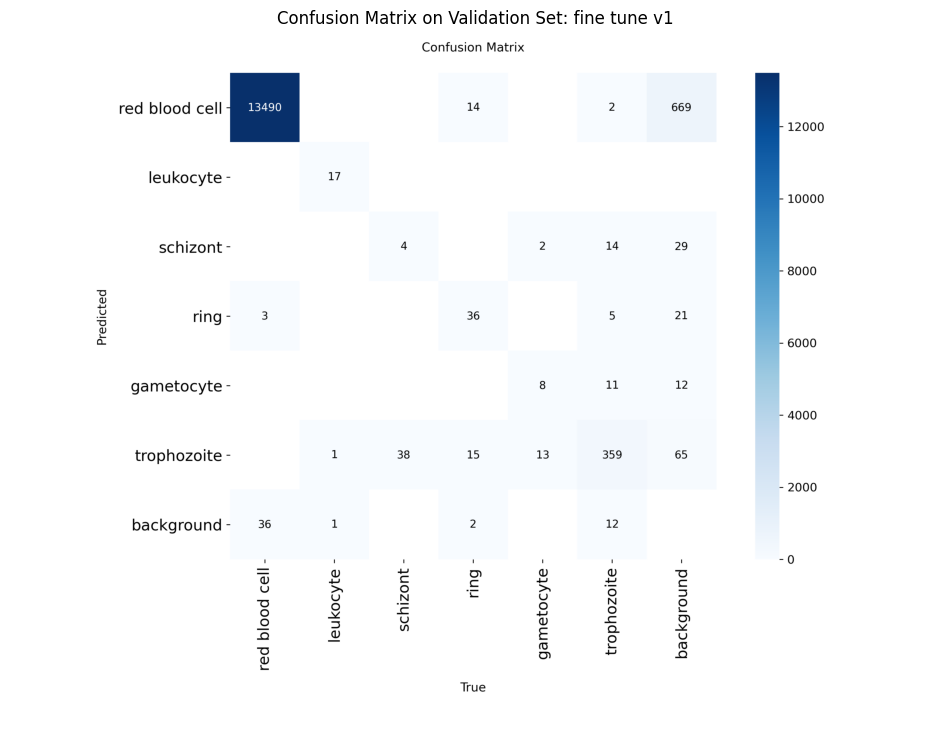

In [13]:
# Find generated confusion matrix plot (assuming the validation run in the first block was successful) and displaying it using Matplotlib.

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Define path to the generated confusion matrix plot
# YOLOv8 typically saves plots in the named validation run folder.
confusion_matrix_path = '/content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/confusion_matrix.png'

# Display the confusion matrix
if os.path.exists(confusion_matrix_path):
    print(f"Displaying confusion matrix from: {confusion_matrix_path}")
    #
    img = mpimg.imread(confusion_matrix_path)
    plt.figure(figsize=(12,12))
    plt.imshow(img)
    plt.title('Confusion Matrix on Validation Set: fine tune v1')
    plt.axis('off')
    plt.show()
else:
    print(f"Error: Confusion matrix plot not found at {confusion_matrix_path}")
    print("Please ensure the validation step ran successfully and check the output directory for generated plots.")

##### *Summary of training & validation results over 200 epochs*

In [10]:
import os
import pandas as pd # Import pandas

RUN_DIR = '/content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune'
# Corrected path to the results.csv file
finetune_results_csv_path = os.path.join(RUN_DIR, 'results.csv')

# Check if the results.csv file exists
if os.path.exists(finetune_results_csv_path):
    # Load the results into a pandas DataFrame
    # Skip the first row as it often contains headers with extra '#' characters
    finetune_df_results = pd.read_csv(finetune_results_csv_path)

    # The first row often contains additional '#' comments. Clean column names.
    finetune_df_results.columns = [col.strip().replace(' ', '').replace('#', '') for col in finetune_df_results.columns]

    # Assuming the first column is 'epoch' (or similar)
    # Find the maximum epoch reached in the logs. The epoch numbers in the CSV are 0-indexed if using default YOLOv8 behavior or may directly reflect actual epoch numbers.
    # Let's check the first column for 'epoch' or similar identifier
    epoch_col = [col for col in finetune_df_results.columns if 'epoch' in col.lower()][0] if any('epoch' in col.lower() for col in finetune_df_results.columns) else None

    if epoch_col:
        # Display all epochs from the CSV file
        print(f"Model summary from '{finetune_results_csv_path}':")
        display(finetune_df_results) # Display the full DataFrame without filtering
    else:
        print("Could not find an 'epoch' column in the results.csv file.")
        display(finetune_df_results)

else:
    print(f"Error: results.csv not found at {finetune_results_csv_path}")
    print("Please ensure training completed successfully and generated the results file.")

Model summary from '/content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/results.csv':


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,63.6315,0.78229,0.91590,1.16336,0.28078,0.31419,0.30398,0.18536,1.21931,1.09173,1.52545,6.699050e-02,3.301280e-06,3.301280e-06
1,2,124.2000,0.73559,0.61065,1.09438,0.62159,0.31169,0.40846,0.31231,0.90983,0.63432,1.16537,3.366050e-02,6.634210e-06,6.634210e-06
2,3,180.9470,0.72145,0.57929,1.07911,0.57838,0.36120,0.41539,0.32230,0.87707,0.59262,1.12172,3.304780e-04,9.965490e-06,9.965490e-06
3,4,239.4110,0.71903,0.56452,1.07334,0.57960,0.36332,0.42619,0.32939,0.87893,0.58059,1.11619,9.994450e-06,9.994450e-06,9.994450e-06
4,5,296.0100,0.71198,0.55347,1.06873,0.56215,0.38359,0.43558,0.33397,0.88887,0.56898,1.11920,9.990130e-06,9.990130e-06,9.990130e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,3699.3000,0.66268,0.36208,0.98892,0.73368,0.77064,0.79265,0.59689,0.94238,0.38045,1.02493,1.541430e-08,1.541430e-08,1.541430e-08
196,197,3749.7100,0.66986,0.36649,0.99913,0.74447,0.76782,0.79627,0.58521,1.00562,0.38953,1.05254,9.867360e-09,9.867360e-09,9.867360e-09
197,198,3800.6500,0.67094,0.36770,0.99934,0.74592,0.77816,0.79444,0.57899,1.02372,0.39351,1.06138,5.551620e-09,5.551620e-09,5.551620e-09
198,199,3850.6900,0.66729,0.36261,0.99727,0.74620,0.77067,0.79475,0.59550,0.96345,0.38256,1.03296,2.468200e-09,2.468200e-09,2.468200e-09


In [11]:
display(finetune_df_results.describe())

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,2.000000e+02,2.000000e+02,2.000000e+02
mean,100.500000,2990.595689,0.685178,0.400387,1.012572,0.720006,0.714617,0.744395,0.565639,0.909290,0.403662,1.032702,5.097824e-04,4.974521e-06,4.974521e-06
std,57.879185,1890.234809,0.013058,0.058063,0.020904,0.079507,0.108279,0.107755,0.082443,0.041321,0.069372,0.045903,5.290029e-03,3.512442e-06,3.512442e-06
min,1.000000,62.285300,0.662680,0.362080,0.988920,0.280780,0.311690,0.303980,0.185360,0.833830,0.361920,0.990260,6.178380e-10,6.178380e-10,6.178380e-10
25%,50.750000,1464.377500,0.678455,0.373415,1.001958,0.724170,0.727250,0.765305,0.578603,0.883785,0.373367,1.011452,1.506448e-06,1.506448e-06,1.506448e-06
50%,100.500000,2773.110000,0.683955,0.379725,1.005930,0.743385,0.757150,0.791530,0.598535,0.902735,0.381120,1.022925,5.039270e-06,4.960730e-06,4.960730e-06
75%,150.250000,4254.967500,0.689455,0.398890,1.012968,0.754543,0.769255,0.797970,0.608835,0.928813,0.398047,1.038253,8.549305e-06,8.436945e-06,8.436945e-06
max,200.000000,7012.310000,0.782290,0.915900,1.163360,0.816080,0.800460,0.805700,0.625200,1.219310,1.091730,1.525450,6.699050e-02,9.994450e-06,9.994450e-06


General Performance is Good:
- The average validation metrics (mAP50 mean:0.744 & mAP50-950.565, precision mean:0.720006	Recall mean:0.714617) indicate that the model is performing well overall.
- Training Instability: The extreme standard deviation and maximum value in train/box_loss are the most concerning findings.
- Model Generalization: The low and stable standard deviation in the validation losses (val/box_loss, val/cls_loss, val/dfl_loss) suggests that despite the noisy training, the model did not overfit and is generalizing well to unseen data.

#### *4.1.3.2 Error Analysis: Fine tune v1*

##### *Training & Validation Classification Loss Curves*

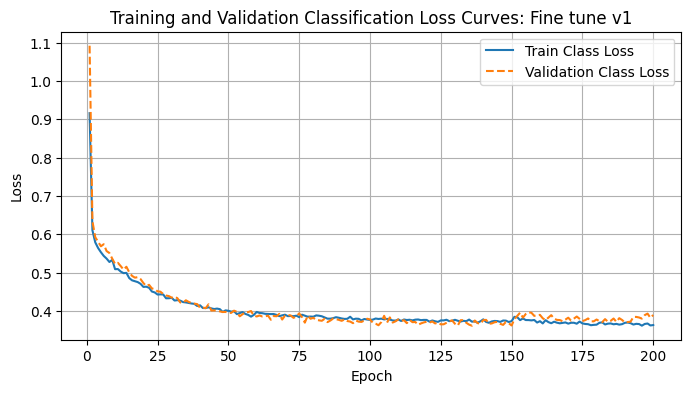

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(finetune_df_results['epoch'], finetune_df_results['train/cls_loss'], label='Train Class Loss', linestyle='-')
plt.plot(finetune_df_results['epoch'], finetune_df_results['val/cls_loss'], label='Validation Class Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Classification Loss Curves: Fine tune v1')
plt.legend()
plt.grid(True)
plt.show()

##### *Training and Validation Bounding Box Loss Curves*

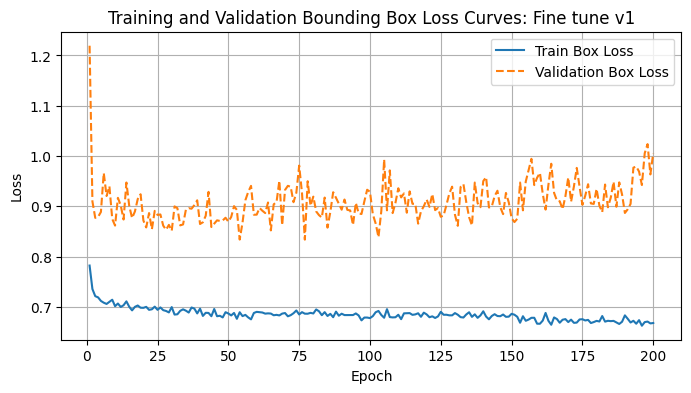

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(finetune_df_results['epoch'], finetune_df_results['train/box_loss'], label='Train Box Loss', linestyle='-')
plt.plot(finetune_df_results['epoch'], finetune_df_results['val/box_loss'], label='Validation Box Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Bounding Box Loss Curves: Fine tune v1')
plt.legend()
plt.grid(True)
plt.show()

##### *Training and Validation Distribution Focal Loss Curves*

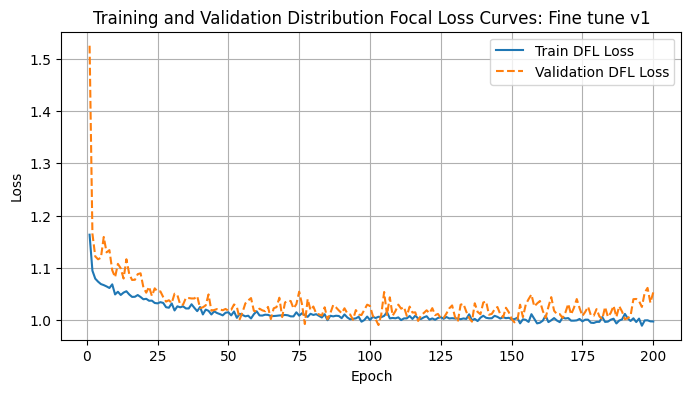

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(finetune_df_results['epoch'], finetune_df_results['train/dfl_loss'], label='Train DFL Loss', linestyle='-')
plt.plot(finetune_df_results['epoch'], finetune_df_results['val/dfl_loss'], label='Validation DFL Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Distribution Focal Loss Curves: Fine tune v1')
plt.legend()
plt.grid(True)
plt.show()

##### *Total Training and Validation Loss Curves (Fine-tune v1)*

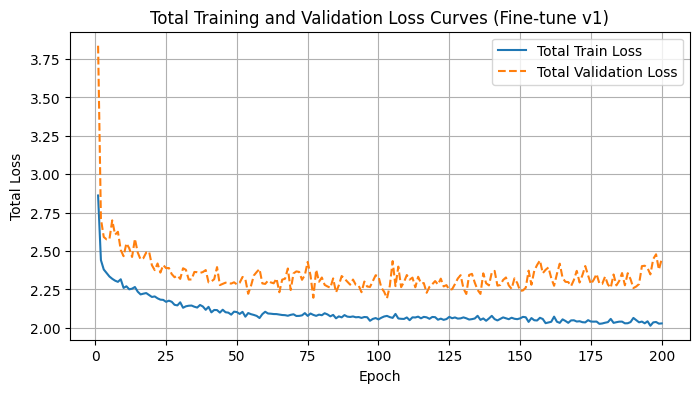

In [12]:
import matplotlib.pyplot as plt

# Calculate total training and validation losses
finetune_df_results['total_train_loss'] = finetune_df_results['train/box_loss'] + finetune_df_results['train/cls_loss'] + finetune_df_results['train/dfl_loss']
finetune_df_results['total_val_loss'] = finetune_df_results['val/box_loss'] + finetune_df_results['val/cls_loss'] + finetune_df_results['val/dfl_loss']

plt.figure(figsize=(8,4))
plt.plot(finetune_df_results['epoch'], finetune_df_results['total_train_loss'], label='Total Train Loss', linestyle='-')
plt.plot(finetune_df_results['epoch'], finetune_df_results['total_val_loss'], label='Total Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Total Training and Validation Loss Curves (Fine-tune v1)')
plt.legend()
plt.grid(True)
plt.show()

##### *Validation metric curves*

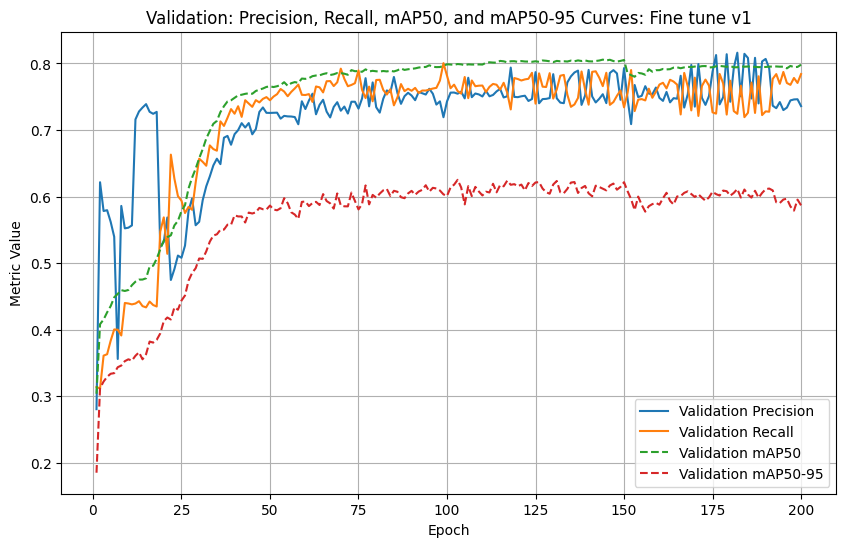

In [18]:
plt.figure(figsize=(10,6))
plt.plot(finetune_df_results['epoch'], finetune_df_results['metrics/precision(B)'], label='Validation Precision', linestyle='-')
plt.plot(finetune_df_results['epoch'], finetune_df_results['metrics/recall(B)'], label='Validation Recall', linestyle='-')
plt.plot(finetune_df_results['epoch'], finetune_df_results['metrics/mAP50(B)'], label='Validation mAP50', linestyle='--')
plt.plot(finetune_df_results['epoch'], finetune_df_results['metrics/mAP50-95(B)'], label='Validation mAP50-95', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Validation: Precision, Recall, mAP50, and mAP50-95 Curves: Fine tune v1')
plt.legend()
plt.grid(True)
plt.show()

##### *Validation F1 scores*

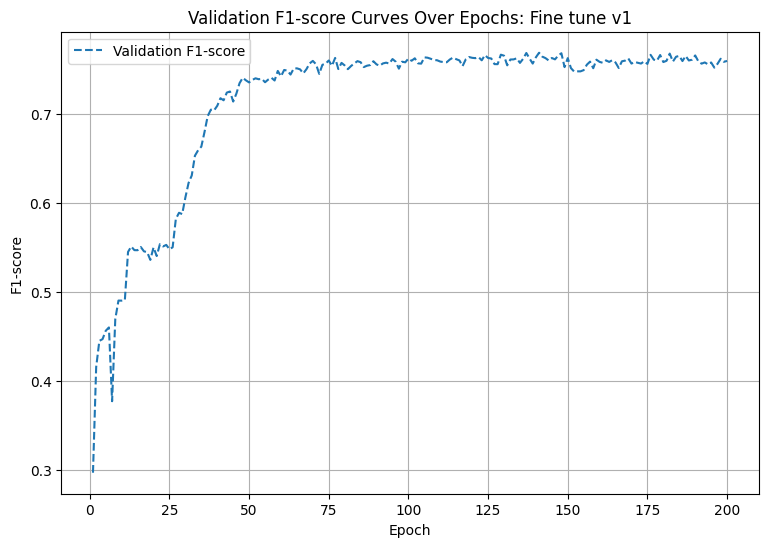

In [19]:
# Calculate F1-scores for all epochs
# Adding F1-score columns to the DataFrame

def calculate_f1(row):
    precision = row['metrics/precision(B)']
    recall = row['metrics/recall(B)']
    if (precision + recall) > 0:
        return 2 * (precision * recall) / (precision + recall)
    else:
        return 0.0

finetune_df_results['val_f1'] = finetune_df_results.apply(calculate_f1, axis=1)

# Plotting F1-scores
plt.figure(figsize=(9,6))
plt.plot(finetune_df_results['epoch'], finetune_df_results['val_f1'], label='Validation F1-score', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('Validation F1-score Curves Over Epochs: Fine tune v1')
plt.legend()
plt.grid(True)
plt.show()

### *4.1.4 Fine tune with extended mosaic augmentation (Fine tune v2)*

#### *Start*

In [ ]:
import os
from ultralytics import YOLO
import torch

# --- CONFIGURATION ---
# CRITICAL INSIGHT: Mosaic turned off at epoch 150, causing performance drop
# Strategy: Resume from best.pt and KEEP mosaic active longer

# Path to your BEST model (epoch 131: mAP50=0.804, mAP50-95=0.623)
PREVIOUS_BEST_MODEL = '/content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/weights/best.pt'

# Path to save new results
SAVE_DIR = '/content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results'

# Path to data.yaml
DATA_YAML_PATH = '/content/drive/MyDrive/yolov8_malaria_finetune/data.yaml'

# New run name
NEW_RUN_NAME = 'yolov8n_malaria_finetune_v2_mosaic_extended'
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Initialize YOLO model with the best previous weights
# Loads your custom-trained weights for continued fine-tuning
model=YOLO(PREVIOUS_BEST_MODEL)

# --- TRAINING HYPERPARAMETERS ---
# Key change: Keep mosaic active throughout training!
EPOCHS = 100  # Train for 100 more epochs
PATIENCE = 40  # Patience for early stopping
LR0 = 0.00001  # Same as previous fine-tuning
LRF = 0.0000001  # Gradual decay
WEIGHT_DECAY = 0.005  #Increased weight decay for regularization

# Initialize YOLO model
print(f"Loading best model from: {PREVIOUS_BEST_MODEL}")
model = YOLO(PREVIOUS_BEST_MODEL)

# Start Training
print(f"\n🎯 Strategy: Keep mosaic active for all {EPOCHS}.")

results = model.train(
    data=DATA_YAML_PATH,
    project=SAVE_DIR,
    name=NEW_RUN_NAME,

    # fine tune run
    epochs=EPOCHS,
    patience=PATIENCE,

    # hyperparameters
    lr0=LR0,
    lrf=LRF,
    weight_decay=WEIGHT_DECAY,
    cos_lr=True,

    # --- Model settings ---
    imgsz=1280,
    batch=8,
    cache=True,
    device=DEVICE,
    optimizer='AdamW',
    workers=2,
    exist_ok=True,
    verbose=True,
    amp=True,

    # --- CRITICAL: Keep mosaic active throughout! ---
    mosaic=1.0,
    close_mosaic=0,      # 🔥 KEY CHANGE: Never close mosaic (0 = disabled)

    # --- Enhanced augmentations ---
    mixup=0.15,          # Moderate mixup
    copy_paste=0.15,     # Copy-paste for rare objects

    # Color augmentations
    hsv_h=0.02,
    hsv_s=0.5,
    hsv_v=0.5,

    # Geometric augmentations
    degrees=180.0,
    translate=0.15,
    scale=0.6,
    shear=5.0,
    perspective=0.0002,
    flipud=0.5,
    fliplr=0.5,

    # Loss weights
    cls=0.5,
    box=7.5,
    dfl=1.5
)

print(f"\n✅ Training complete! Results saved to {SAVE_DIR}/{NEW_RUN_NAME}")

Loading best model from: /content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune/weights/best.pt

🎯 Strategy: Keep mosaic active for all 100.
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=0, cls=0.5, compile=False, conf=None, copy_paste=0.15, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/yolov8_malaria_finetune/data.yaml, degrees=180.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.02, hsv_s=0.5, hsv_v=0.5, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=1e-05, lrf=1e-07, mask_ratio=4, max_det=300, mixup=0.15, mode

#### *4.1.4.1 Model evaluation - Fine tune with extended mosaic augmentation*

##### *Model Evaluation*

In [38]:
from ultralytics import YOLO
import pandas as pd
import numpy as np

# --- CONFIGURATION ---
# Path to newly trained model (use best.pt for best validation performance)
NEW_MODEL_PATH = '/content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune_v2_mosaic_extended/weights/best.pt'

DATA_YAML_PATH = '/content/drive/MyDrive/yolov8_malaria_finetune/data.yaml'

print("🔍 Loading trained model and running validation...\n")

# Load the trained model
model = YOLO(NEW_MODEL_PATH)

# Run validation on the test set
metrics = model.val(data=DATA_YAML_PATH)

print("\n✅ Validation complete!")
print(f"📁 Full results saved in: {NEW_MODEL_PATH.replace('/weights/best.pt', '')}")

🔍 Loading trained model and running validation...

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.2 ms, read: 101.4±60.6 MB/s, size: 1963.5 KB)
val: Scanning /content/drive/MyDrive/yolov8_malaria_finetune/labels/val.cache... 206 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 206/206 180.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 19.8s/it 4:18
                   all        206      14083      0.784      0.705      0.791      0.602
        red blood cell        206      13529       0.96      0.991      0.993      0.764
             leukocyte         16         19      0.902      0.842      0.888      0.593
              schizont         34         42      0.635       0.29      0.484      0.372
                  ring         50         67      0.74

##### *Confusion matrix*

Displaying confusion matrix from: /content/runs/detect/val6/confusion_matrix.png


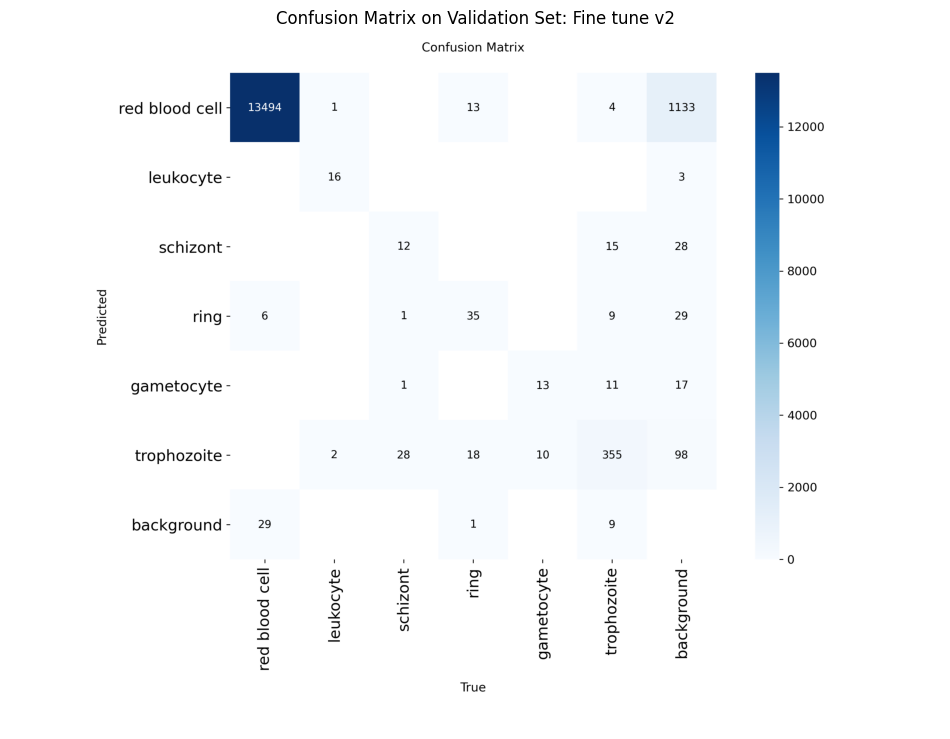

In [39]:
# Find generated confusion matrix plot (assuming the validation run in the first block was successful) and displaying it using Matplotlib.

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Define path to the generated confusion matrix plot
# YOLOv8 typically saves plots in the named validation run folder.
fine_tune_v2_conf_matrix_path = '/content/runs/detect/val6/confusion_matrix.png'
# Display the confusion matrix
if os.path.exists(confusion_matrix_path):
    print(f"Displaying confusion matrix from: {fine_tune_v2_conf_matrix_path}")
    #
    img = mpimg.imread(fine_tune_v2_conf_matrix_path)
    plt.figure(figsize=(12,12))
    plt.imshow(img)
    plt.title('Confusion Matrix on Validation Set: Fine tune v2')
    plt.axis('off')
    plt.show()
else:
    print(f"Error: Confusion matrix plot not found at {fine_tune_v2_conf_matrix_path}")
    print("Please ensure the validation step ran successfully and check the output directory for generated plots.")

##### *Summary of training & validation results over 48 epochs:Fine tune with extended augmentation*

In [5]:
import os
import pandas as pd # Import pandas

# Define the run directory for the second fine-tune run
RUN_DIR_V2 = '/content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune_v2_mosaic_extended'
finetune_v2_results_csv_path = os.path.join(RUN_DIR_V2, 'results.csv')

# Make finetune_v2_df_results accessible globally for later use
global finetune_v2_df_results

# Check if the results.csv file exists
if os.path.exists(finetune_v2_results_csv_path):
    # Load the results into a pandas DataFrame
    # Skip the first row as it often contains headers with extra '#' characters
    finetune_v2_df_results = pd.read_csv(finetune_v2_results_csv_path)

    # The first row often contains additional '#' comments. Clean column names.
    finetune_v2_df_results.columns = [col.strip().replace(' ', '').replace('#', '') for col in finetune_v2_df_results.columns]

    # Assuming the first column is 'epoch' (or similar)
    # Let's check the first column for 'epoch' or similar identifier
    epoch_col = [col for col in finetune_v2_df_results.columns if 'epoch' in col.lower()][0] if any('epoch' in col.lower() for col in finetune_v2_df_results.columns) else None

    if epoch_col:
        # Display all epochs from the CSV file
        print(f"Model summary from '{finetune_v2_results_csv_path}':")
        display(finetune_v2_df_results)
    else:
        print("Could not find an 'epoch' column in the results.csv file.")
        display(finetune_v2_df_results)

else:
    print(f"Error: results.csv not found at {finetune_v2_results_csv_path}")
    print("Please ensure training completed successfully and generated the results file.")


Model summary from '/content/drive/MyDrive/yolov8_malaria_finetune/yolov8n_finetune_train_results/yolov8n_malaria_finetune_v2_mosaic_extended/results.csv':


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,123.306,0.95552,0.52852,1.16039,0.74644,0.72247,0.77507,0.58031,0.90485,0.40995,1.02036,0.066990,0.000003,0.000003
1,2,249.363,0.89784,0.49168,1.11678,0.75875,0.71990,0.77680,0.59807,0.81141,0.39586,0.97983,0.033661,0.000007,0.000007
2,3,379.339,0.90776,0.50113,1.13131,0.80168,0.71415,0.79206,0.59686,0.86820,0.38797,0.99918,0.000330,0.000010,0.000010
3,4,509.722,0.89865,0.48991,1.11700,0.79571,0.71236,0.78730,0.58082,0.92605,0.39350,1.02170,0.000010,0.000010,0.000010
4,5,637.727,0.89333,0.47852,1.11055,0.71089,0.75528,0.78674,0.58798,0.89094,0.38690,1.00717,0.000010,0.000010,0.000010
5,6,763.873,0.89615,0.48488,1.12120,0.77709,0.71385,0.78857,0.59356,0.86318,0.38202,0.99541,0.000010,0.000010,0.000010
6,7,893.868,0.89368,0.48273,1.11927,0.78944,0.70692,0.78891,0.58745,0.89442,0.38960,1.00975,0.000010,0.000010,0.000010
7,8,1025.420,0.91217,0.48568,1.12792,0.78482,0.70478,0.79083,0.60125,0.84523,0.38100,0.98994,0.000010,0.000010,0.000010
8,9,1153.150,0.88691,0.47736,1.11242,0.77967,0.72335,0.78767,0.58231,0.93154,0.39569,1.02285,0.000010,0.000010,0.000010
9,10,1280.900,0.87900,0.47614,1.11065,0.78048,0.70734,0.78581,0.58557,0.90159,0.39058,1.01072,0.000010,0.000010,0.000010


In [6]:
# Summarize results for finetune with extended augmentation
display(finetune_v2_df_results.describe())

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
count,48.00,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,24.50,3130.313500,0.886344,0.473404,1.109624,0.780125,0.728131,0.786698,0.592856,0.877864,0.383220,1.002450,0.002112,0.000008,0.000008
std,14.00,1787.160432,0.014272,0.012573,0.010722,0.015605,0.010373,0.002973,0.004983,0.022535,0.006953,0.008913,0.010726,0.000002,0.000002
min,1.00,123.306000,0.864340,0.454050,1.091180,0.710890,0.704780,0.775070,0.580310,0.811410,0.373200,0.979830,0.000005,0.000003,0.000003
25%,12.75,1631.055000,0.878027,0.465987,1.103613,0.773748,0.722100,0.785748,0.590625,0.865405,0.378513,0.996830,0.000007,0.000007,0.000007
50%,24.50,3138.670000,0.884340,0.470550,1.108495,0.782500,0.730845,0.786955,0.593585,0.875510,0.381750,1.001210,0.000009,0.000008,0.000008
75%,36.25,4627.057500,0.892590,0.477520,1.112780,0.789200,0.735223,0.788455,0.596185,0.889147,0.386763,1.007215,0.000010,0.000010,0.000010
max,48.00,6129.330000,0.955520,0.528520,1.160390,0.807120,0.755280,0.792060,0.601250,0.934860,0.409950,1.024060,0.066990,0.000010,0.000010


#### *4.1.4.2 Error Analysis: Fine tune with extended augmentation*

##### *Training & Validation Classification Loss Curves (Fine-tune v2)*

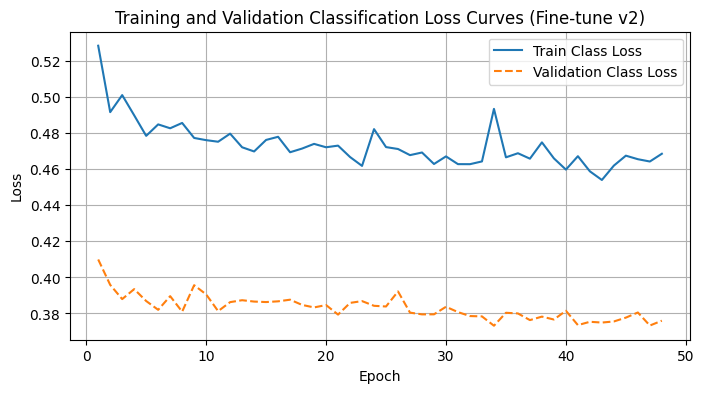

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(finetune_v2_df_results['epoch'], finetune_v2_df_results['train/cls_loss'], label='Train Class Loss', linestyle='-')
plt.plot(finetune_v2_df_results['epoch'], finetune_v2_df_results['val/cls_loss'], label='Validation Class Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Classification Loss Curves (Fine-tune v2)')
plt.legend()
plt.grid(True)
plt.show()

##### *Training and Validation Bounding Box Loss Curves (Fine-tune v2)*

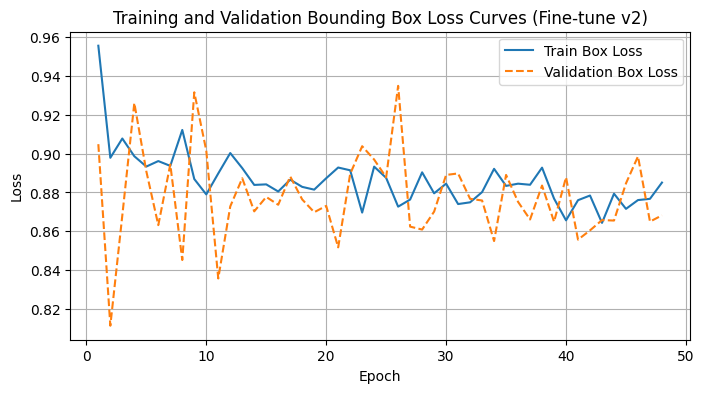

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(finetune_v2_df_results['epoch'], finetune_v2_df_results['train/box_loss'], label='Train Box Loss', linestyle='-')
plt.plot(finetune_v2_df_results['epoch'], finetune_v2_df_results['val/box_loss'], label='Validation Box Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Bounding Box Loss Curves (Fine-tune v2)')
plt.legend()
plt.grid(True)
plt.show()

##### *Training and Validation Distribution Focal Loss Curves (Fine-tune v2)*

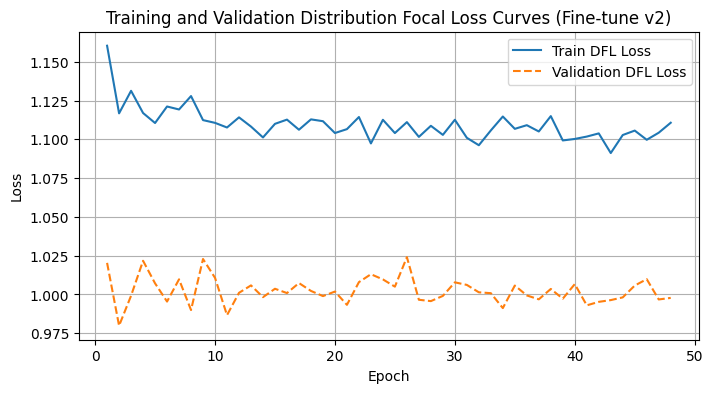

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(finetune_v2_df_results['epoch'], finetune_v2_df_results['train/dfl_loss'], label='Train DFL Loss', linestyle='-')
plt.plot(finetune_v2_df_results['epoch'], finetune_v2_df_results['val/dfl_loss'], label='Validation DFL Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Distribution Focal Loss Curves (Fine-tune v2)')
plt.legend()
plt.grid(True)
plt.show()

##### *Total Training and Validation Loss Curves (Fine-tune v2)*

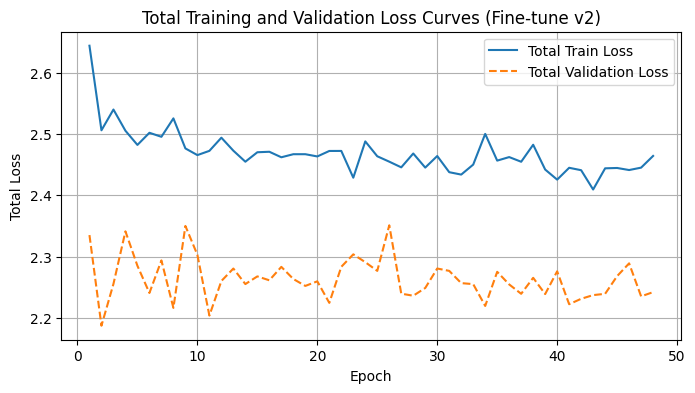

In [9]:
import matplotlib.pyplot as plt

# Calculate total training and validation losses
finetune_v2_df_results['total_train_loss'] = finetune_v2_df_results['train/box_loss'] + finetune_v2_df_results['train/cls_loss'] + finetune_v2_df_results['train/dfl_loss']
finetune_v2_df_results['total_val_loss'] = finetune_v2_df_results['val/box_loss'] + finetune_v2_df_results['val/cls_loss'] + finetune_v2_df_results['val/dfl_loss']

plt.figure(figsize=(8,4))
plt.plot(finetune_v2_df_results['epoch'], finetune_v2_df_results['total_train_loss'], label='Total Train Loss', linestyle='-')
plt.plot(finetune_v2_df_results['epoch'], finetune_v2_df_results['total_val_loss'], label='Total Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Total Training and Validation Loss Curves (Fine-tune v2)')
plt.legend()
plt.grid(True)
plt.show()

##### *Validation Precision and Recall Curves (Fine-tune v2)*

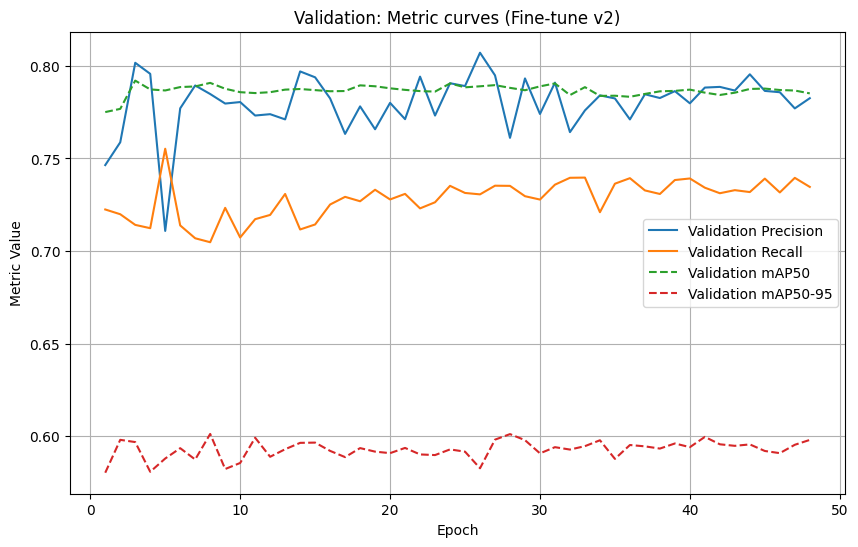

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(finetune_v2_df_results['epoch'], finetune_v2_df_results['metrics/precision(B)'], label='Validation Precision', linestyle='-')
plt.plot(finetune_v2_df_results['epoch'], finetune_v2_df_results['metrics/recall(B)'], label='Validation Recall', linestyle='-')
plt.plot(finetune_v2_df_results['epoch'], finetune_v2_df_results['metrics/mAP50(B)'], label='Validation mAP50', linestyle='--')
plt.plot(finetune_v2_df_results['epoch'], finetune_v2_df_results['metrics/mAP50-95(B)'], label='Validation mAP50-95', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Validation: Metric curves (Fine-tune v2)')
plt.legend()
plt.grid(True)
plt.show()

##### *Validation F1 scores (Fine-tune v2)*

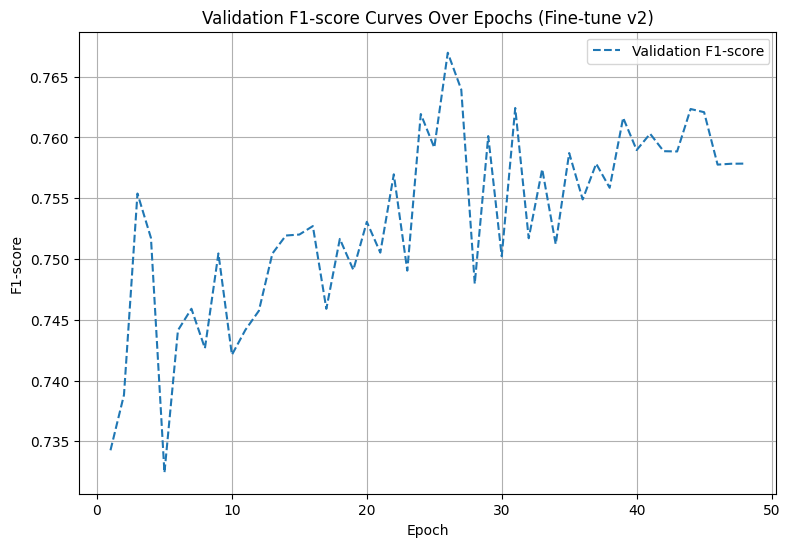

In [48]:
# Calculate F1-scores for all epochs
# Adding F1-score columns to the DataFrame

def calculate_f1(row):
    precision = row['metrics/precision(B)']
    recall = row['metrics/recall(B)']
    if (precision + recall) > 0:
        return 2 * (precision * recall) / (precision + recall)
    else:
        return 0.0

finetune_v2_df_results['val_f1'] = finetune_v2_df_results.apply(calculate_f1, axis=1)

# Plotting F1-scores
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))
plt.plot(finetune_v2_df_results['epoch'], finetune_v2_df_results['val_f1'], label='Validation F1-score', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('Validation F1-score Curves Over Epochs (Fine-tune v2)')
plt.legend()
plt.grid(True)
plt.show()

## 4.2 Overall interpretation & Selection of best.pt to use

**Comparison of confusion matrix**

----------
**Schizont- (42 instances)**
- Fine tune V1
  - FN (Background): 29
  - Misclassified: 13 (4 to Leukocyte, 2 to Gametocyte, 2 to Trophozoite, 5 to Ring)
- Fine tune V2
  - FN (Background): 28
  - Misclassified: 14 (13 to Gametocyte, 1 to Trophozoite)

- Fine tune V2 is marginally better at detection (1 fewer FN). The primary error for this rare class is still missing it completely (high FN).
- Fine tune v1 misclassifies less overall (13 vs 14), but fine tune V2 concentrates its error on Gametocyte (13 misclassifications). This suggests V2's aggressive training caused it to confuse Schizonts and Gametocytes more often.

-----------
**Gametocyte (23 instances)**
- Fine tune v1
  - FN (Background): 12
  - Misclassified: 11 (8 to Schizont, 2 to Trophozoite, 1 to Ring)
- Fine tune v2
  - FN (Background): 17
  - Misclassified: 6 (5 to Schizont, 1 to Trophozoite)

- V1 is better at detecting Gametocytes (5 fewer FN). V2 seems to miss Gametocytes more often.
- Both models primarily confuse Gametocyte with Schizont. The high concentration of errors between Schizont/Gametocyte suggests a true biological ambiguity in their features, amplified by the models' aggressive training.

------------
**Leukocyte (19 instances)**

- V1: FN (Background): 1
- V2: FN (Background): 3
- V1 has fewer False Negatives (FN), meaning it misses the rare Leukocyte less often.

**Comparison of the Loss Curves**

1. Loss Magnitude
- Fine tune 1 Validation Loss: approx 0.37 (Final) vs. Fine tune v2 Validation Loss: approx 0.375 (Final)
- Both models converge to virtually the same low loss value, confirming the metrics mAP 50-95 values were $0.624 vs 0.623.
2. Convergence Rate:
- fine tune 1 - Steady, gradual decay until approx Epoch 100 for first fine tune.
fine tune v2 - Reaches near-final loss within the first 25 epochs
- Fine tune V2 converges much faster due to loading strong base weights and using aggressive augmentations/low LR from the start.

3. Stability:
- Fine tune 1 - Relatively smooth and stable in the 0-150$ range.
- Fine tune v2 - More erratic/noisy training loss curve.The extended, aggressive augmentations in V2 cause the training loss to oscillate more, which is expected but confirms the increased variance during training.



OVERALL

- For deployment: $\text{Fine Tune 1 (V1)}$ $\text{best.pt}$ has significantly better Recall (fewer missed detections) for common (Trophozoite) and rare (Gametocyte) classes. Accuracy ($0.624$) is marginally higher.

- Training Strategy (Future Use)$\text {Fine Tune v2}$ Configuration Optimal for fast iteration/new data. It proves the performance ceiling can be reached in just 48 epochs without significant overfitting.